In [74]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from math import log

In [75]:
%cd Input/

[Errno 2] No such file or directory: 'Input/'
/home/anas/Walmart-Sales-Forcasting/Input


In [76]:
training_data = pd.read_parquet('Merged.parquet')
test_data = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

In [77]:
corr_matrix = training_data.drop('Type' ,axis= 1).corr()
corr_matrix['Weekly_Sales'].sort_values(ascending=False)

Weekly_Sales    1.000000
Size            0.243828
Dept            0.148032
MarkDown5       0.050465
MarkDown1       0.047172
MarkDown3       0.038562
MarkDown4       0.037467
Month           0.028409
WeekOfYear      0.027673
MarkDown2       0.020716
IsHoliday       0.012774
Fuel_Price     -0.000120
Date           -0.000663
Temperature    -0.002312
Day            -0.006187
Year           -0.010111
CPI            -0.020921
Unemployment   -0.025864
Store          -0.085195
Name: Weekly_Sales, dtype: float64

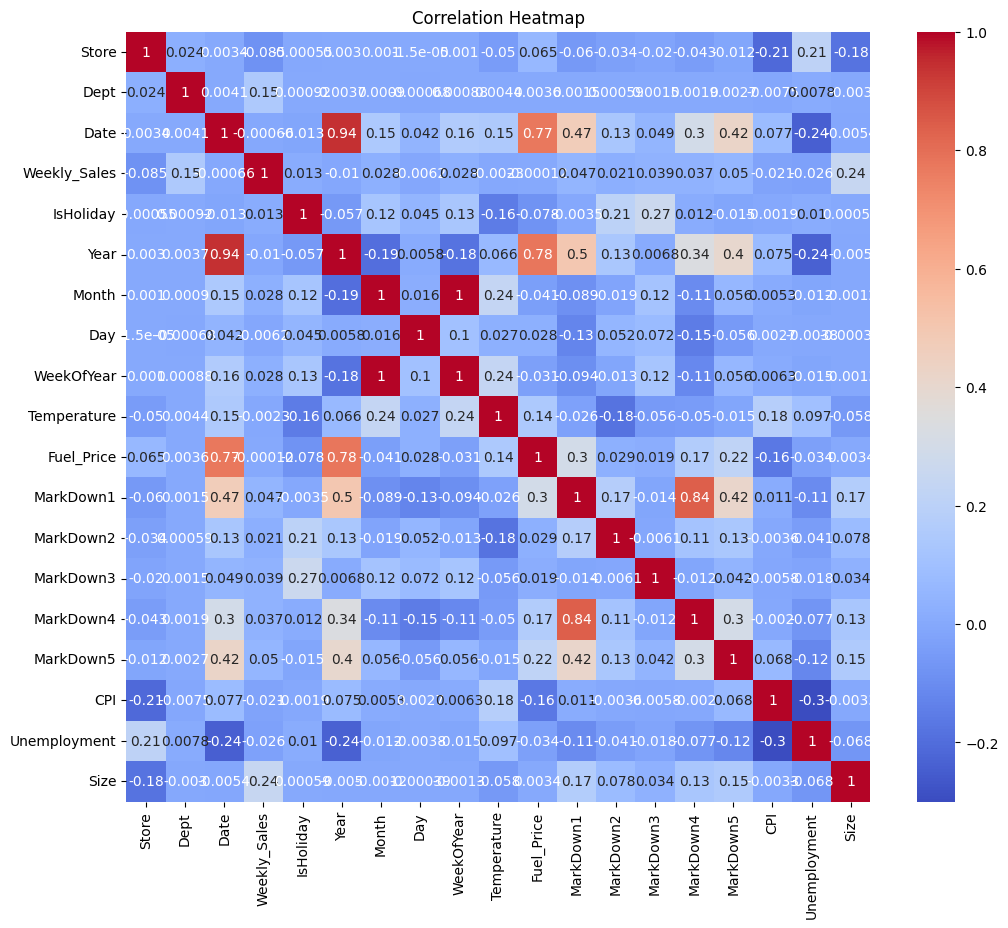

In [78]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix , annot= True , cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()


adding some usecase depandent features 
the holidays are whighted 5 times important 
adding domain specif feature 
+ adding my lag feature in manual and automated 
+ for modeling we have the statsical models (arima) and traditional ml approches 

In [79]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = (df.Date.dt.isocalendar().week)*1.0  
    return df

In [80]:
def makecountdown(data):
    data['CountDown_Thansksgiving'] = (pd.to_datetime(data["Year"].astype(str)+"-11-24", format="%Y-%m-%d") 
                                     - pd.to_datetime(data["Date"], format="%Y-%m-%d")).dt.days.astype(int)

    data['Countdown_Christmas'] = (pd.to_datetime(data["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - 
                                   pd.to_datetime(data["Date"], format="%Y-%m-%d")).dt.days.astype(int)
    return data


In [81]:
def Onehotholidays(data):
    data['SuperBowlWeek'] = data['WeekOfYear'].apply(lambda x: 1 if x == 6 else 0)
    data['LaborDay'] = data['WeekOfYear'].apply(lambda x: 1 if x == 36 else 0)
    data['Tranksgiving'] = data['WeekOfYear'].apply(lambda x: 1 if x == 47 else 0)
    data['Christmas'] = data['WeekOfYear'].apply(lambda x: 1 if x == 52 else 0)
    return data

In [82]:
def mergedata(data , features , stores):
    merged_data = pd.merge(data , features ,on = ['Store' , 'Date'] , how ='inner')

    merged_data = pd.merge(merged_data , stores , on='Store' , how = 'inner')

    merged_data.fillna({"MarkDown1" : 0 , 
                        "MarkDown2" : 0 ,
                        "MarkDown3" : 0,
                        "MarkDown4" : 0 ,
                        "MarkDown5" : 0}, inplace= True)


    merged_data = merged_data.rename(columns={'IsHoliday_x': 'IsHoliday'})
    merged_data.drop('IsHoliday_y' , inplace= True , axis= 1)
    merged_data['IsHoliday'] = merged_data['IsHoliday'].astype('int8')

    merged_data['Type'] = merged_data['Type'].astype('category')

    return merged_data
    

In [83]:
test_data = split_date(test_data)
features['Date'] = pd.to_datetime(features['Date'])
test_data = mergedata(test_data , features , stores)
test_data = makecountdown(test_data)
test_data = Onehotholidays(test_data)

training_data = makecountdown(training_data)
training_data = Onehotholidays(training_data)

In [84]:
all_data = pd.concat([training_data , test_data] , ignore_index= True)

In [85]:
test_data.shape

(115064, 25)

In [86]:
all_data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Day,WeekOfYear,Temperature,...,CPI,Unemployment,Type,Size,CountDown_Thansksgiving,Countdown_Christmas,SuperBowlWeek,LaborDay,Tranksgiving,Christmas
0,1,1,2010-02-05,24924.50,0,2010,2,5,5.0,42.31,...,211.096358,8.106,A,151315,292,322,0,0,0,0
1,1,2,2010-02-05,50605.27,0,2010,2,5,5.0,42.31,...,211.096358,8.106,A,151315,292,322,0,0,0,0
2,1,3,2010-02-05,13740.12,0,2010,2,5,5.0,42.31,...,211.096358,8.106,A,151315,292,322,0,0,0,0
3,1,4,2010-02-05,39954.04,0,2010,2,5,5.0,42.31,...,211.096358,8.106,A,151315,292,322,0,0,0,0
4,1,5,2010-02-05,32229.38,0,2010,2,5,5.0,42.31,...,211.096358,8.106,A,151315,292,322,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536629,45,98,2013-06-28,NaN,0,2013,6,28,26.0,76.05,...,NaN,NaN,B,118221,149,179,0,0,0,0
536630,45,98,2013-07-05,NaN,0,2013,7,5,27.0,77.50,...,NaN,NaN,B,118221,142,172,0,0,0,0
536631,45,98,2013-07-12,NaN,0,2013,7,12,28.0,79.37,...,NaN,NaN,B,118221,135,165,0,0,0,0
536632,45,98,2013-07-19,NaN,0,2013,7,19,29.0,82.84,...,NaN,NaN,B,118221,128,158,0,0,0,0


In [87]:
all_data.isna().sum()
all_data.fillna({
    'CPI':all_data['CPI'].median(),
    'Unemployment':all_data['Unemployment'].mean()},inplace = True )


In [88]:
all_data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month',
       'Day', 'WeekOfYear', 'Temperature', 'Fuel_Price', 'MarkDown1',
       'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Type', 'Size', 'CountDown_Thansksgiving',
       'Countdown_Christmas', 'SuperBowlWeek', 'LaborDay', 'Tranksgiving',
       'Christmas'],
      dtype='object')

In [89]:
all_data['Type'] = all_data['Type'].astype('category')
all_data["TimeSeriesID"] = all_data['Store'].astype(str) + " " + all_data['Dept'].astype(str)

all_data["TimeSeriesID"] = pd.factorize(all_data["TimeSeriesID"])[0]
all_data['Type'] = all_data['Type'].cat.codes

In [90]:
all_data["log_weekly_sales"]= all_data['Weekly_Sales'].apply(lambda x:log(x)if x > 0 else float('nan'))

In [91]:
all_data['TimeSeriesID']

0            0
1            1
2            2
3            3
4            4
          ... 
536629    3323
536630    3323
536631    3323
536632    3323
536633    3323
Name: TimeSeriesID, Length: 536634, dtype: int64

In [92]:
all_data.reset_index(inplace=True , drop= True)
all_data.set_index(['Date' ,'TimeSeriesID'] , inplace=True , drop= True)
all_data.sort_index(level='TimeSeriesID' , inplace= True)

Try auto_ts model for single time series and all of them and add features using ts_fresh

In [93]:
def make_lag(num_lag , column = 'Weekly_Sales'):
    lagged_column_name = f'lag_{num_lag}{"" if column == "Weekly_Sales" else "_log"}'
    all_data[lagged_column_name] = all_data.groupby('TimeSeriesID')[column].shift(periods=num_lag)

In [94]:
make_lag(1)
make_lag(2)
make_lag(3)
make_lag(4)

In [95]:
make_lag(1 , 'log_weekly_sales')
make_lag(2 , 'log_weekly_sales')
make_lag(3 , 'log_weekly_sales')
make_lag(3 , 'log_weekly_sales')

In [96]:
#making sure that lags only for specif time series 
all_data.xs(2, level=1)[['Weekly_Sales', 'lag_2', 'lag_3', 'lag_4']]

,Weekly_Sales,lag_2,lag_3,lag_4
Date,,,,
2010-02-05,13740.12,NaN,NaN,NaN
2010-02-12,10887.84,NaN,NaN,NaN
2010-02-19,11523.47,13740.12,NaN,NaN
2010-02-26,11135.17,10887.84,13740.12,NaN
2010-03-05,12275.58,11523.47,10887.84,13740.12
...,...,...,...,...
2013-06-28,NaN,NaN,NaN,NaN
2013-07-05,NaN,NaN,NaN,NaN
2013-07-12,NaN,NaN,NaN,NaN


In [97]:
all_data['expanding_mean'] = all_data.groupby('TimeSeriesID')["Weekly_Sales"].transform(lambda x:x.expanding(2).mean())
all_data['expanding_log_mean'] = all_data.groupby('TimeSeriesID')['log_weekly_sales'].transform(lambda x:x.expanding(2).mean())

all_data["rolling_std"] = all_data.groupby('TimeSeriesID')['Weekly_Sales'].transform(lambda x: x.expanding(2).std())
all_data["rolling_log_std"] = all_data.groupby('TimeSeriesID')['log_weekly_sales'].transform(lambda x:x.expanding(2).std())

In [98]:
all_data.xs(5, level=1)[['expanding_mean', 'expanding_log_mean', 'rolling_std', 'rolling_log_std']]

,expanding_mean,expanding_log_mean,rolling_std,rolling_log_std
Date,,,,
2010-02-05,NaN,NaN,NaN,NaN
2010-02-12,7442.01500,8.888327,2394.242348,0.327448
2010-02-19,6981.43000,8.828721,1871.527140,0.253515
2010-02-26,6547.21250,8.762777,1757.627731,0.245440
2010-03-05,6082.02000,8.679799,1843.627332,0.282148
...,...,...,...,...
2013-06-28,4801.78014,8.370437,3317.432691,0.422512
2013-07-05,4801.78014,8.370437,3317.432691,0.422512
2013-07-12,4801.78014,8.370437,3317.432691,0.422512


In [99]:
all_data[['Weekly_Sales','lag_1','lag_2','lag_3','lag_4',"expanding_mean",'rolling_std']].isnull().sum()

Weekly_Sales      115064
lag_1             115237
lag_2             115418
lag_3             115595
lag_4             115775
expanding_mean      3409
rolling_std         3409
dtype: int64

In [100]:
all_data.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month,Day,WeekOfYear,Temperature,Fuel_Price,...,lag_2,lag_3,lag_4,lag_1_log,lag_2_log,lag_3_log,expanding_mean,expanding_log_mean,rolling_std,rolling_log_std
count,536634.000000,536634.000000,421570.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.0,536634.000000,536634.000000,...,421216.000000,421039.000000,420859.000000,420064.000000,419904.000000,419754.000000,533225.000000,533051.000000,533225.000000,533051.000000
mean,22.208621,44.277301,15981.258123,0.071909,2011.354241,6.295203,15.653921,25.231581,58.771762,3.408310,...,15994.620702,16001.318546,16008.140521,8.522914,8.525128,8.527233,15958.684449,8.522628,3608.465122,0.366138
std,12.790580,30.527358,22711.183519,0.258338,1.040218,3.333808,8.773285,14.554119,18.678716,0.430861,...,22716.044159,22718.468614,22720.930719,2.046029,2.042824,2.039809,21558.543873,1.957657,5695.426458,0.469143
min,1.000000,1.000000,-4988.940000,0.000000,2010.000000,1.000000,1.000000,1.0,-7.290000,2.472000,...,-4988.940000,-4988.940000,-4988.940000,-4.605170,-4.605170,-4.605170,-825.000000,-4.605170,0.000000,0.000000
25%,11.000000,18.000000,2079.650000,0.000000,2010.000000,3.000000,8.000000,13.0,45.250000,3.041000,...,2089.702500,2095.000000,2100.765000,7.661339,7.663544,7.665664,2381.783916,7.630606,646.923278,0.133186
50%,22.000000,37.000000,7612.030000,0.000000,2011.000000,6.000000,16.000000,24.0,60.060000,3.523000,...,7625.050000,7630.880000,7637.940000,8.944817,8.945641,8.946513,8064.600938,8.934977,1745.812199,0.235288
75%,33.000000,74.000000,20205.852500,0.000000,2012.000000,9.000000,23.000000,37.0,73.230000,3.744000,...,20222.867500,20232.605000,20242.845000,9.917291,9.917573,9.918037,20231.926842,9.873391,4199.245148,0.387031
max,45.000000,99.000000,693099.360000,1.000000,2013.000000,12.000000,31.000000,52.0,101.950000,4.468000,...,693099.360000,693099.360000,693099.360000,13.448929,13.448929,13.448929,222933.630000,12.287998,100455.011732,8.009113


In [101]:
# from statsmodels.tsa.stattools import adfuller
# for i in range(1,4):
#     adf_test = adfuller(training_data['Weekly_Sales'].loc[(training_data['Store'] == i) & (training_data['Dept'] == i)]
#     )
#     print(adf_test[1])

In [102]:
#this is  the top store and depts from eda 
filtered_data = all_data.loc[(all_data['Store'].isin([20,4,14 , 13 ,2 ,27 ,6 ,1 ,39 ])& all_data['Dept'].isin([92,95,38,72,2 ,90 ,40 ,91 ,13 ,8]))]

In [103]:
filtered_data.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month', 'Day',
       'WeekOfYear', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type',
       'Size', 'CountDown_Thansksgiving', 'Countdown_Christmas',
       'SuperBowlWeek', 'LaborDay', 'Tranksgiving', 'Christmas',
       'log_weekly_sales', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_1_log',
       'lag_2_log', 'lag_3_log', 'expanding_mean', 'expanding_log_mean',
       'rolling_std', 'rolling_log_std'],
      dtype='object')

In [104]:
def preaperdata(data):
    #cols related to original distrubation
    unseen = data.loc[data['Weekly_Sales'].isnull()]
    cols = ["Weekly_Sales" , "lag_1" ,"lag_2","lag_3","lag_4" ,"expanding_mean" ,"rolling_std"]
    data.drop(cols , inplace=True ,axis = 1 )
    data.dropna(subset=['log_weekly_sales'], inplace=True)
    data.dropna(subset=['lag_1_log' , "lag_2_log" , "lag_3_log" , "expanding_log_mean" , "rolling_log_std"], inplace=True)
    data.reset_index(level='TimeSeriesID' , inplace =  True )
    return data , unseen

In [105]:
data , unseen = preaperdata(all_data)

In [106]:
unseen.shape

(115064, 37)

In [107]:
data.shape

(408207, 31)

In [108]:
# filtered_data , unseen = preaperdata(filtered_data)
data.isnull().any()

TimeSeriesID               False
Store                      False
Dept                       False
IsHoliday                  False
Year                       False
Month                      False
Day                        False
WeekOfYear                 False
Temperature                False
Fuel_Price                 False
MarkDown1                  False
MarkDown2                  False
MarkDown3                  False
MarkDown4                  False
MarkDown5                  False
CPI                        False
Unemployment               False
Type                       False
Size                       False
CountDown_Thansksgiving    False
Countdown_Christmas        False
SuperBowlWeek              False
LaborDay                   False
Tranksgiving               False
Christmas                  False
log_weekly_sales           False
lag_1_log                  False
lag_2_log                  False
lag_3_log                  False
expanding_log_mean         False
rolling_lo

In [109]:
timeseries = data.groupby("TimeSeriesID")

train_data = timeseries.apply(lambda timeseries:timeseries.head(120))
test = timeseries.apply(lambda timeseries:timeseries.tail(20))
test.reset_index(level= 0 , drop= True , inplace=True)
val_timeseries = test.groupby("TimeSeriesID")
val_data = val_timeseries.apply(lambda timeseries:timeseries.head(10))
test_data = val_timeseries.apply(lambda timeseries:timeseries.tail(10))

/tmp/ipykernel_74425/318006642.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = timeseries.apply(lambda timeseries:timeseries.head(120))
/tmp/ipykernel_74425/318006642.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = timeseries.apply(lambda timeseries:timeseries.tail(20))
/tmp/ipykernel_74425/318006642.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

In [110]:
test

,TimeSeriesID,Store,Dept,IsHoliday,Year,Month,Day,WeekOfYear,Temperature,Fuel_Price,...,SuperBowlWeek,LaborDay,Tranksgiving,Christmas,log_weekly_sales,lag_1_log,lag_2_log,lag_3_log,expanding_log_mean,rolling_log_std
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-15,0,1,1,0,2012,6,15,24.0,79.35,3.393,...,0,0,0,0,9.773312,9.779397,9.684429,9.738822,9.973782,0.359419
2012-06-22,0,1,1,0,2012,6,22,25.0,78.39,3.346,...,0,0,0,0,9.719169,9.773312,9.779397,9.684429,9.971745,0.358690
2012-06-29,0,1,1,0,2012,6,29,26.0,84.88,3.286,...,0,0,0,0,9.662868,9.719169,9.773312,9.779397,9.969293,0.358311
2012-07-06,0,1,1,0,2012,7,6,27.0,81.57,3.227,...,0,0,0,0,9.788266,9.662868,9.719169,9.773312,9.967868,0.357247
2012-07-13,0,1,1,0,2012,7,13,28.0,77.12,3.256,...,0,0,0,0,9.715119,9.788266,9.662868,9.719169,9.965893,0.356539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-27,3328,45,49,0,2012,7,27,30.0,77.20,3.647,...,0,0,0,0,2.639057,2.482404,2.708050,2.567254,3.801924,0.842939
2012-09-07,3328,45,49,1,2012,9,7,36.0,75.70,3.911,...,0,1,0,0,1.609438,-2.813411,1.609438,1.088562,3.557037,1.304667
2012-03-16,3329,45,77,0,2012,3,16,11.0,50.56,3.862,...,0,0,0,0,5.857933,5.164786,5.857933,5.164786,5.422868,0.399082


In [111]:
def split_xy(data):
    y = data['log_weekly_sales']
    X = data.drop(columns=["log_weekly_sales"])
    return X ,y 

In [112]:
X_train ,y_train = split_xy(train_data)
X_val ,y_val = split_xy(val_data)
X_test, y_test = split_xy(test_data)

In [113]:
y_train.shape

(354081,)

In [114]:
X_val

TimeSeriesID  Store  Dept  IsHoliday  Year  Month  \
TimeSeriesID Date                                                            
0            2012-06-15             0      1     1          0  2012      6   
             2012-06-22             0      1     1          0  2012      6   
             2012-06-29             0      1     1          0  2012      6   
             2012-07-06             0      1     1          0  2012      7   
             2012-07-13             0      1     1          0  2012      7   
...                               ...    ...   ...        ...   ...    ...   
3328         2012-03-09          3328     45    49          0  2012      3   
             2012-03-16          3328     45    49          0  2012      3   
3329         2012-03-16          3329     45    77          0  2012      3   
             2012-03-30          3329     45    77          0  2012      3   
             2012-04-20          3329     45    77          0  2012      4   

                         Day  WeekOfYear  Temperature  Fuel_Price  ...  \
TimeSeriesID Date                                                  ...   
0            2012-06-15   15        24.0        79.35       3.393  ...   
             2012-06-22   22        25.0        78.39       3.346  ...   
             2012-06-29   29        26.0        84.88       3.286  ...   
             2012-07-06    6        27.0        81.57       3.227  ...   
             2012-07-13   13        28.0        77.12       3.256  ...   
...                      ...         ...          ...         ...  ...   
3328         2012-03-09    9        10.0        45.52       3.848  ...   
             2012-03-16   16        11.0        50.56       3.862  ...   
3329         2012-03-16   16        11.0        50.56       3.862  ...   
             2012-03-30   30        13.0        50.04       3.953  ...   
             2012-04-20   20        16.0        63.13       4.027  ...   

                         Countdown_Christmas  SuperBowlWeek  LaborDay  \
TimeSeriesID Date                                                       
0            2012-06-15                  192              0         0   
             2012-06-22                  185              0         0   
             2012-06-29                  178              0         0   
             2012-07-06                  171              0         0   
             2012-07-13                  164              0         0   
...                                      ...            ...       ...   
3328         2012-03-09                  290              0         0   
             2012-03-16                  283              0         0   
3329         2012-03-16                  283              0         0   
             2012-03-30                  269              0         0   
             2012-04-20                  248              0         0   

                         Tranksgiving  Christmas  lag_1_log  lag_2_log  \
TimeSeriesID Date                                                        
0            2012-06-15             0          0   9.779397   9.684429   
             2012-06-22             0          0   9.773312   9.779397   
             2012-06-29             0          0   9.719169   9.773312   
             2012-07-06             0          0   9.662868   9.719169   
             2012-07-13             0          0   9.788266   9.662868   
...                               ...        ...        ...        ...   
3328         2012-03-09             0          0   4.585070   4.467057   
             2012-03-16             0          0   4.346658   4.585070   
3329         2012-03-16             0          0   5.164786   5.857933   
             2012-03-30             0          0   5.857933   5.164786   
             2012-04-20             0          0   5.105703   5.857933   

                         lag_3_log  expanding_log_mean  rolling_log_std  
TimeSeriesID Date                                           

In [115]:
X_test

TimeSeriesID  Store  Dept  IsHoliday  Year  Month  \
TimeSeriesID Date                                                            
0            2012-08-24             0      1     1          0  2012      8   
             2012-08-31             0      1     1          0  2012      8   
             2012-09-07             0      1     1          1  2012      9   
             2012-09-14             0      1     1          0  2012      9   
             2012-09-21             0      1     1          0  2012      9   
...                               ...    ...   ...        ...   ...    ...   
3328         2012-07-27          3328     45    49          0  2012      7   
             2012-09-07          3328     45    49          1  2012      9   
3329         2012-03-16          3329     45    77          0  2012      3   
             2012-03-30          3329     45    77          0  2012      3   
             2012-04-20          3329     45    77          0  2012      4   

                         Day  WeekOfYear  Temperature  Fuel_Price  ...  \
TimeSeriesID Date                                                  ...   
0            2012-08-24   24        34.0        77.66       3.620  ...   
             2012-08-31   31        35.0        80.49       3.638  ...   
             2012-09-07    7        36.0        83.96       3.730  ...   
             2012-09-14   14        37.0        74.97       3.717  ...   
             2012-09-21   21        38.0        69.87       3.721  ...   
...                      ...         ...          ...         ...  ...   
3328         2012-07-27   27        30.0        77.20       3.647  ...   
             2012-09-07    7        36.0        75.70       3.911  ...   
3329         2012-03-16   16        11.0        50.56       3.862  ...   
             2012-03-30   30        13.0        50.04       3.953  ...   
             2012-04-20   20        16.0        63.13       4.027  ...   

                         Countdown_Christmas  SuperBowlWeek  LaborDay  \
TimeSeriesID Date                                                       
0            2012-08-24                  122              0         0   
             2012-08-31                  115              0         0   
             2012-09-07                  108              0         1   
             2012-09-14                  101              0         0   
             2012-09-21                   94              0         0   
...                                      ...            ...       ...   
3328         2012-07-27                  150              0         0   
             2012-09-07                  108              0         1   
3329         2012-03-16                  283              0         0   
             2012-03-30                  269              0         0   
             2012-04-20                  248              0         0   

                         Tranksgiving  Christmas  lag_1_log  lag_2_log  \
TimeSeriesID Date                                                        
0            2012-08-24             0          0   9.760235   9.687811   
             2012-08-31             0          0   9.698086   9.760235   
             2012-09-07             0          0   9.721980   9.698086   
             2012-09-14             0          0   9.815878   9.721980   
             2012-09-21             0          0   9.884112   9.815878   
...                               ...        ...        ...        ...   
3328         2012-07-27             0          0   2.482404   2.708050   
             2012-09-07             0          0  -2.813411   1.609438   
3329         2012-03-16             0          0   5.164786   5.857933   
             2012-03-30             0          0   5.857933   5.164786   
             2012-04-20             0          0   5.105703   5.857933   

                         lag_3_log  expanding_log_mean  rolling_log_std  
TimeSeriesID Date                                           

In [116]:
# from keras.preprocessing.sequence import TimeseriesGenerator
# def transform_into_seq_optimized(gens):
#     X = np.empty((0, 4, 30), dtype='float32')
#     y = np.empty((0,), dtype='float32')

#     for generator in gens:
#         for data, target in generator:
#             data = np.array(data, dtype='float32')
#             target = np.array(target, dtype='float32')

#     X = np.concatenate((X, data.flatten()))
#     y = np.concatenate((y, target))

#     return X, y

In [117]:
# train_generator = create_generators(X_train , y_train)
# val_generator =  create_generators(X_val , y_val)
# test_generator = create_generators(X_test ,  y_test )

In [118]:
def transform_into_seq(gens):
    X = np.array([])  # Initialize an empty array for accumulating data
    y = np.array([])  # Initialize an empty array for accumulating targets

    for generator in gens:
        for i in range(len(generator)):
            data, target = generator[i]

            # Convert data and target to NumPy arrays if not already
            data = np.array(data, dtype='float32')
            target = np.array(target, dtype='float32')

            # Concatenate data and target to the accumulating arrays
            X = np.concatenate((X, data.flatten()))
            y = np.concatenate((y, target.flatten()))
            
    X = X.reshape(-1, 4, 30)
    y = y.reshape(-1, )
            
    return X,y 

In [119]:
# X_train_seq , y_train_seq = transform_into_seq(train_generator)
# X_val_seq , y_val_seq = transform_into_seq(val_generator)
# X_test_seq , y_test_seq = transform_into_seq(test_generator)

In [120]:
# y_test_seq.shape

In [121]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import * 
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.losses import mean_squared_error
# from tensorflow.keras.metrics import mse
# from tensorflow.keras.optimizers import Adam



# Model1 = Sequential()

# Model1.add(LSTM(units=32 , input_shape = (4,30) ,return_sequences=True))
# Model1.add(LSTM(units= 8))
# Model1.add(Dropout(0.2))
# Model1.add(Dense(1,'linear'))



# Model1.compile(loss = mean_squared_error , optimizer = Adam(learning_rate = 0.0001) , metrics=[mse])

# cp1 = [ModelCheckpoint('model1/', save_best_only=True) ,EarlyStopping(monitor = 'loss' , patience=3) ]


In [122]:
# history = Model1.fit(X_train_seq , y_train_seq ,validation_data =(X_val_seq , y_val_seq)  ,epochs =50, verbose=1, shuffle=False ,callbacks =[cp1] )

In [123]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')

In [124]:
# Model1.save('C:\\Users\\Anas\\Walmart Sales\\Models')

In [125]:
# from tensorflow.keras.models import load_model
# model = load_model('Model1/')

In [126]:
# train_predictions = Model1.predict(X_test_seq).flatten()
# train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test_seq.flatten()})
# train_results

In [127]:
# train_results['Actuals'] , y_train.tail()

In [128]:
# plt.plot(train_results['Train Predictions'][60:100])
# plt.plot(train_results['Actuals'][60:100])
# plt.legend()
# plt.show()

Xgboost Model and infernce


In [129]:
import xgboost as xgb 

In [130]:
X_train['WeekOfYear'] = X_train['WeekOfYear'].astype(int)
X_val['WeekOfYear'] = X_val['WeekOfYear'].astype(int)
X_test['WeekOfYear'] = X_test['WeekOfYear'].astype(int)


In [131]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test,label = y_test)
# # Set XGBoost parameters
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'eta': 0.1,
#     'max_depth': 3,
#     'min_child_weight': 1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'nthread': 4,
#     'seed': 42
# }

# # Placeholder lists for storing evaluation results
# evals_result = {}

# # Train the XGBoost model
# num_rounds = 1000
# watchlist = [(dtrain, 'train'), (dval, 'eval')]
# model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=10, verbose_eval=100, evals_result=evals_result)

# # Extract evaluation results for training and validation data
# train_rmse = evals_result['train']['rmse']
# val_rmse = evals_result['eval']['rmse']

# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split

# # Set the parameters
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'eta': 0.1,
#     'max_depth': 3,
#     'min_child_weight': 1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'nthread': 4,
#     'seed': 42
# }

# # Train the XGBoost model using scikit-learn's API
# model = XGBRegressor(**params, n_estimators=1000, early_stopping_rounds=10, verbose=100, random_state=42)
# model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# # Extract evaluation results for training and validation data
# evals_result = model.evals_result()
# train_rmse = evals_result['validation_0']['rmse']
# val_rmse = evals_result['validation_1']['rmse']

# # Predictions
# y_train_pred = model.predict(X_train)
# y_val_pred = model.predict(X_val)

# # Calculate RMSE
# train_rmse_scikit = mean_squared_error(y_train, y_train_pred, squared=False)
# val_rmse_scikit = mean_squared_error(y_val, y_val_pred, squared=False)

# print(f"XGBoost Training RMSE (scikit-learn): {train_rmse_scikit}")
# print(f"XGBoost Validation RMSE (scikit-learn): {val_rmse_scikit}")

In [132]:
# model.save_model('model.json')

In [133]:
model = xgb.Booster()

In [134]:

model.load_model("../Models/model.json")

In [135]:
model.best_iteration# # Plot the learning curve


291

infernce of xgboost model 
the infernce with splited test data

In [136]:
predication = model.predict(dtest)

In [137]:
predication = pd.DataFrame(predication ,index= y_test.index , columns=['predcation'])
predication["acutal"]  = y_test
predication

predcation    acutal
TimeSeriesID Date                            
0            2012-08-24    9.797899  9.698086
             2012-08-31    9.749413  9.721980
             2012-09-07    9.815354  9.815878
             2012-09-14    9.805806  9.884112
             2012-09-21    9.866529  9.865344
...                             ...       ...
3328         2012-07-27    3.028505  2.639057
             2012-09-07    2.992265  1.609438
3329         2012-03-16    5.423836  5.857933
             2012-03-30    5.763481  5.105703
             2012-04-20    5.282617  5.164786

[31339 rows x 2 columns]

In [138]:
series_one = predication.loc[2,:,:]

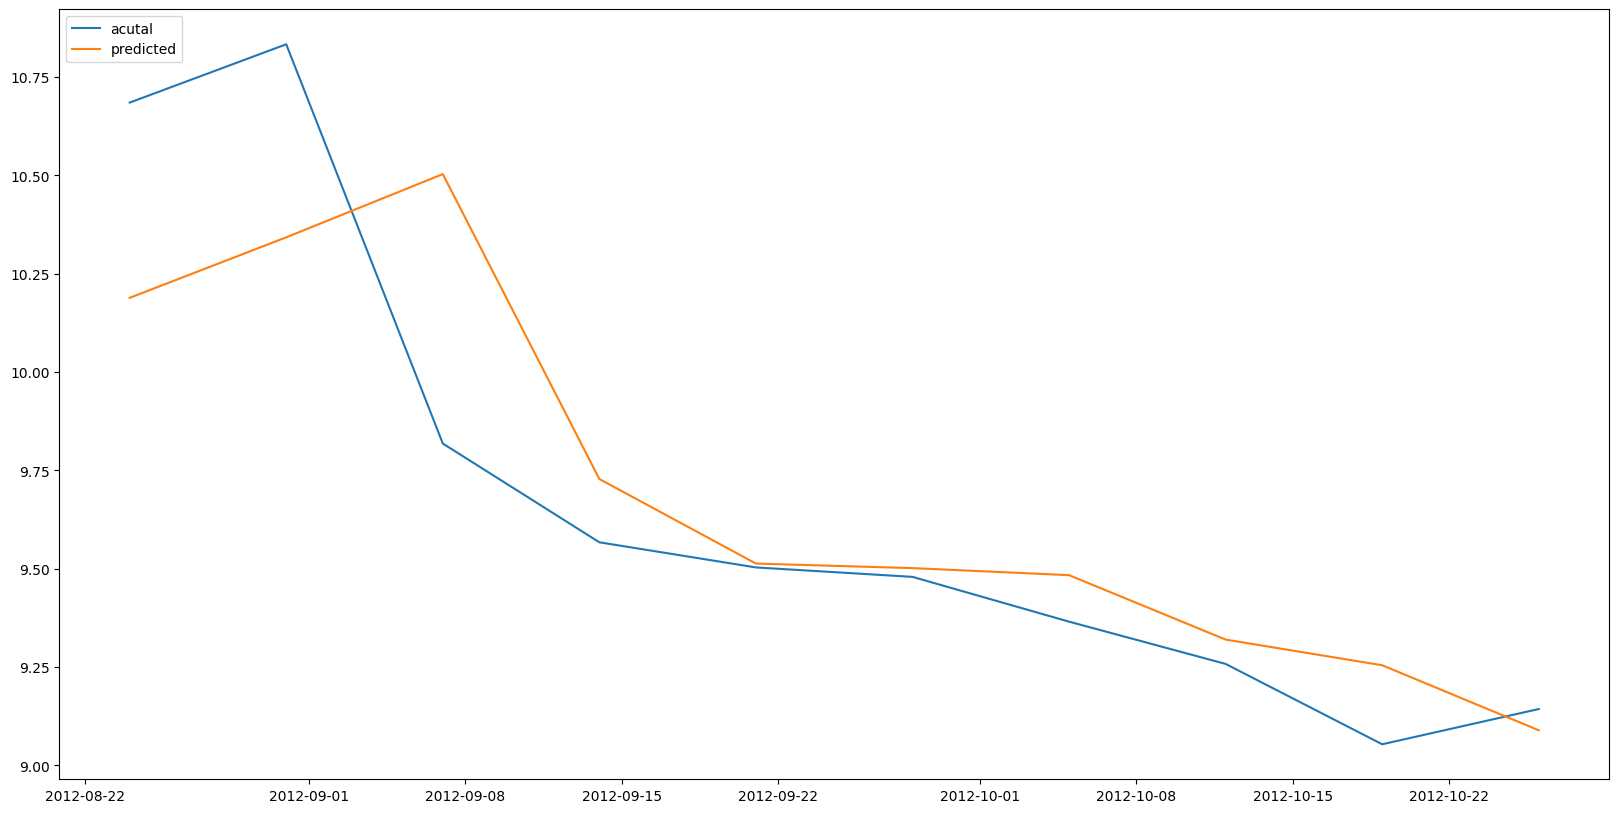

In [139]:
plt.figure(figsize=(20,10))
plt.plot(series_one['acutal'])
plt.plot(series_one['predcation'])
plt.legend(['acutal','predicted'] , loc='upper left')
plt.show()

In [140]:
predication['predict_sales'] = np.exp(predication['acutal'])
predication['acutal_sales'] = np.exp(predication['predcation'])

In [141]:
predication.describe()

,predcation,acutal,predict_sales,acutal_sales
count,31339.000000,31339.000000,31339.000000,31339.000000
mean,8.164649,8.146228,14673.613562,14527.337891
std,2.389855,2.462096,21488.848694,20918.929688
min,-4.217469,-4.605170,0.010000,0.014736
25%,7.238138,7.240768,1395.165000,1391.500244
50%,8.795907,8.778639,6494.030000,6607.145508
75%,9.823346,9.825030,18490.825000,18459.708008
max,12.187190,12.169724,192860.850000,196258.906250


In [142]:
predication

predcation    acutal  predict_sales  acutal_sales
TimeSeriesID Date                                                         
0            2012-08-24    9.797899  9.698086       16286.40  17995.900391
             2012-08-31    9.749413  9.721980       16680.24  17144.169922
             2012-09-07    9.815354  9.815878       18322.37  18312.777344
             2012-09-14    9.805806  9.884112       19616.22  18138.755859
             2012-09-21    9.866529  9.865344       19251.50  19274.314453
...                             ...       ...            ...           ...
3328         2012-07-27    3.028505  2.639057          14.00     20.666311
             2012-09-07    2.992265  1.609438           5.00     19.930769
3329         2012-03-16    5.423836  5.857933         350.00    226.747314
             2012-03-30    5.763481  5.105703         164.96    318.454834
             2012-04-20    5.282617  5.164786         175.00    196.884384

[31339 rows x 4 columns]

Text(0, 0.5, 'Frequency')

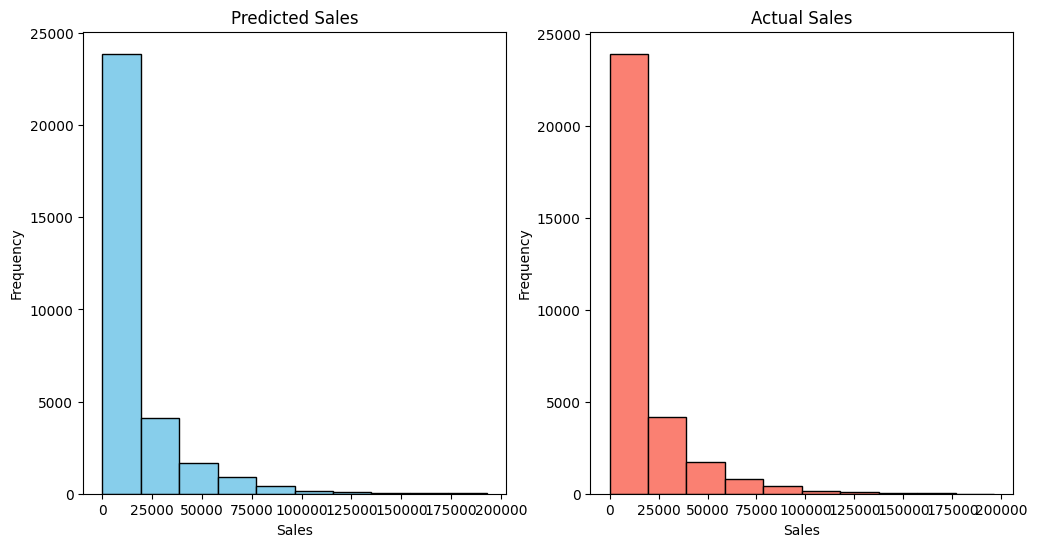

In [143]:
#plot for predication distrbuation and real distrbuation
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].hist(predication['predict_sales'], bins=10, color='skyblue', edgecolor='black')
ax[0].set_title('Predicted Sales')

# Plot the histogram for 'actual_sales' on the second subplot
ax[1].hist(predication['acutal_sales'], bins=10, color='salmon', edgecolor='black')
ax[1].set_title('Actual Sales')

# Set labels and show the plots
ax[0].set_xlabel('Sales')
ax[0].set_ylabel('Frequency')
ax[1].set_xlabel('Sales')
ax[1].set_ylabel('Frequency')

predication on unseen data

In [144]:
unseen.shape

(115064, 37)

In [145]:
unseen.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month', 'Day',
       'WeekOfYear', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type',
       'Size', 'CountDown_Thansksgiving', 'Countdown_Christmas',
       'SuperBowlWeek', 'LaborDay', 'Tranksgiving', 'Christmas',
       'log_weekly_sales', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_1_log',
       'lag_2_log', 'lag_3_log', 'expanding_mean', 'expanding_log_mean',
       'rolling_std', 'rolling_log_std'],
      dtype='object')

In [146]:
unseen.head(5)

,,Store,Dept,Weekly_Sales,IsHoliday,Year,Month,Day,WeekOfYear,Temperature,Fuel_Price,...,lag_2,lag_3,lag_4,lag_1_log,lag_2_log,lag_3_log,expanding_mean,expanding_log_mean,rolling_std,rolling_log_std
Date,TimeSeriesID,,,,,,,,,,,,,,,,,,,,,
2012-11-02,0,1,1,NaN,0,2012,11,2,44.0,55.32,3.386,...,24185.27,22764.01,21904.47,10.217963,10.093499,10.032936,22513.322937,9.953428,9854.349032,0.343276
2012-11-09,0,1,1,NaN,0,2012,11,9,45.0,61.24,3.314,...,27390.81,24185.27,22764.01,NaN,10.217963,10.093499,22513.322937,9.953428,9854.349032,0.343276
2012-11-16,0,1,1,NaN,0,2012,11,16,46.0,52.92,3.252,...,NaN,27390.81,24185.27,NaN,NaN,10.217963,22513.322937,9.953428,9854.349032,0.343276
2012-11-23,0,1,1,NaN,1,2012,11,23,47.0,56.23,3.211,...,NaN,NaN,27390.81,NaN,NaN,NaN,22513.322937,9.953428,9854.349032,0.343276
2012-11-30,0,1,1,NaN,0,2012,11,30,48.0,52.34,3.207,...,NaN,NaN,NaN,NaN,NaN,NaN,22513.322937,9.953428,9854.349032,0.343276


In [147]:
def cleanr(data):
    cols = ["Weekly_Sales" , "lag_1" ,"lag_2","lag_3","lag_4" ,"expanding_mean" ,"rolling_std"]
    data.drop(cols , inplace=True ,axis = 1 )
    return data 

In [148]:
unseen = cleanr(unseen)

/tmp/ipykernel_74425/1280970763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(cols , inplace=True ,axis = 1 )


In [149]:
unseen

,,Store,Dept,IsHoliday,Year,Month,Day,WeekOfYear,Temperature,Fuel_Price,MarkDown1,...,SuperBowlWeek,LaborDay,Tranksgiving,Christmas,log_weekly_sales,lag_1_log,lag_2_log,lag_3_log,expanding_log_mean,rolling_log_std
Date,TimeSeriesID,,,,,,,,,,,,,,,,,,,,,
2012-11-02,0,1,1,0,2012,11,2,44.0,55.32,3.386,6766.44,...,0,0,0,0,NaN,10.217963,10.093499,10.032936,9.953428,0.343276
2012-11-09,0,1,1,0,2012,11,9,45.0,61.24,3.314,11421.32,...,0,0,0,0,NaN,NaN,10.217963,10.093499,9.953428,0.343276
2012-11-16,0,1,1,0,2012,11,16,46.0,52.92,3.252,9696.28,...,0,0,0,0,NaN,NaN,NaN,10.217963,9.953428,0.343276
2012-11-23,0,1,1,1,2012,11,23,47.0,56.23,3.211,883.59,...,0,0,1,0,NaN,NaN,NaN,NaN,9.953428,0.343276
2012-11-30,0,1,1,0,2012,11,30,48.0,52.34,3.207,2460.03,...,0,0,0,0,NaN,NaN,NaN,NaN,9.953428,0.343276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-02-15,3339,37,29,0,2013,2,15,7.0,57.68,3.475,1008.10,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-26,3339,37,29,0,2013,7,26,30.0,83.28,3.620,178.00,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-15,3340,42,30,0,2013,2,15,7.0,45.80,3.612,1061.18,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


ARIMA MODEL TESTING 

In [152]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [158]:
X_train['log_weekly_sales'] = y_train

p=d=q=range(0,5)
pqd = list(itertools.product(p,d,q))

best_aic = np.inf  
best_params = None

for param in pqd:
    try:
        arima_model = ARIMA(X_train['log_weekly_sales'], order=param)
        arima_model_fit = arima_model.fit()
        print(param, arima_model_fit.aic)
        if current_aic < best_aic:
            best_aic = current_aic
            best_params = param
        
    except:
        continue

/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0, 0, 0) 1509958.9960330157


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0, 0, 1) 1156940.889875916


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0, 0, 2) 954542.3368556316


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0, 0, 3) 845544.2539139141


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0, 0, 4) 772068.1001698253


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0, 1, 0) 557620.3753620784


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0, 1, 1) 537940.33042761


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0, 1, 2) 535138.2348338832


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0, 1, 3) 533881.8282582051


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0, 1, 4) 533570.6079787187


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 2, 0) 870266.7307350666


/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/anas/miniconda3/envs/Walmart/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.p

TimeSeriesID  Date      
0             2010-02-26     9.873211
              2010-03-05     9.990944
              2010-03-12     9.954342
              2010-03-19    10.004989
              2010-03-26    10.174629
                              ...    
3328          2012-07-27     2.639057
              2012-09-07     1.609438
3329          2012-03-16     5.857933
              2012-03-30     5.105703
              2012-04-20     5.164786
Name: log_weekly_sales, Length: 354081, dtype: float64